In [1]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import corner

from scipy.spatial.distance import cdist

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

plot_kwds={'alpha':0.25, 's':20, 'linewidths':0}
palette = sns.color_palette('deep', 12)

In [2]:
Dataset  = pd.read_csv('SampleS1.txt',sep='\t')

In [3]:
X_position = Dataset.X
Y_position = Dataset.Y
A_amplitude = Dataset.A

In [4]:
#Remove all points at zero
X_position_cl = X_position[np.where(A_amplitude>0)[0]]
Y_position_cl = Y_position[np.where(A_amplitude>0)[0]]
A_amplitude_cl = A_amplitude[np.where(A_amplitude>0)[0]]

In [5]:
Data_use = np.vstack([X_position_cl,A_amplitude_cl]).T
Data_use_y = np.vstack([Y_position_cl,A_amplitude_cl]).T

In [10]:
Dataset_sample = [X_position,Y_position,A_amplitude]

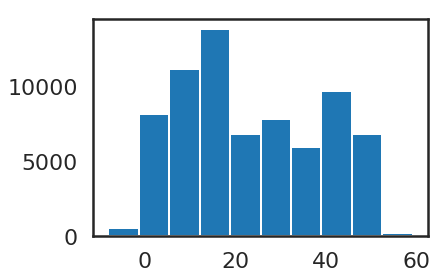

In [13]:
plt.hist(X_position);

In [11]:
corner.corner(Dataset_sample)

AssertionError: I don't believe that you want more dimensions than samples!

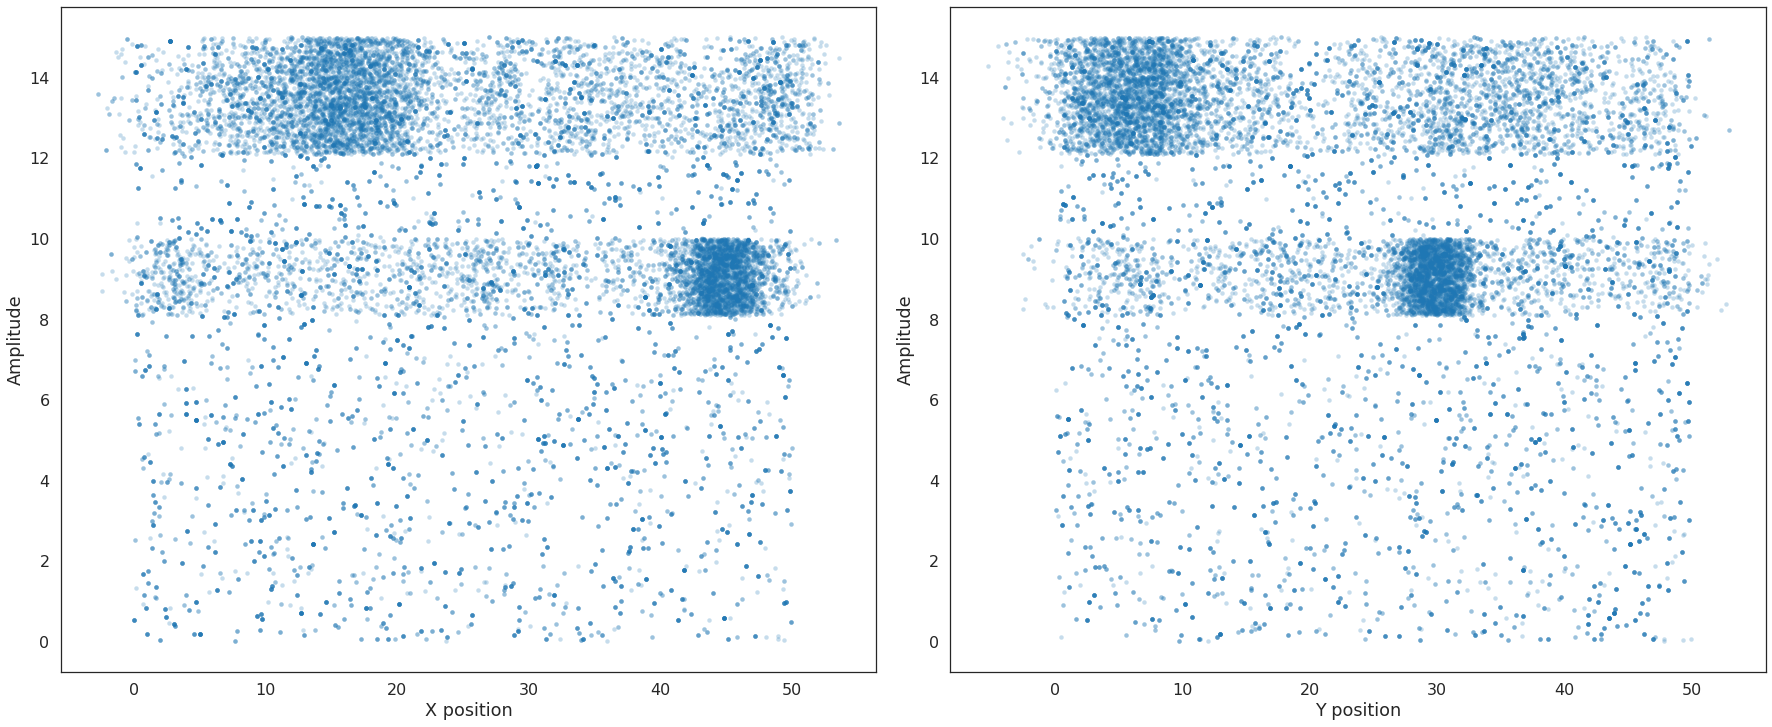

In [24]:
# Plot Amplitude as a fucntion of X position

plt.figure(figsize=(25,20))

plt.subplot(221)
plt.scatter(X_position_cl,A_amplitude_cl,**plot_kwds)
plt.xlabel('X position')
plt.ylabel('Amplitude')

plt.subplot(222)
plt.scatter(Y_position_cl,A_amplitude_cl,**plot_kwds)
plt.xlabel('Y position')
plt.ylabel('Amplitude')

plt.tight_layout()

## HDBSCAN 

In [7]:
import hdbscan

In [8]:
# The parameters were set abitrarily
# Clustering on the Ampitude vs. X position
clusterer = hdbscan.HDBSCAN(min_cluster_size=400,gen_min_span_tree=False,min_samples=400,leaf_size=50)
clusterer.fit(Data_use)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=50,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=400, min_samples=400, p=None,
    prediction_data=False)

In [9]:
# Clustering on the Amplitude vs. Y poisition
clusterer1 = hdbscan.HDBSCAN(min_cluster_size=400,gen_min_span_tree=False,min_samples=400,leaf_size=50)
clusterer1.fit(Data_use_y)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=50,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=400, min_samples=400, p=None,
    prediction_data=False)

## Visualizing the clustered data points with a Dendrogram

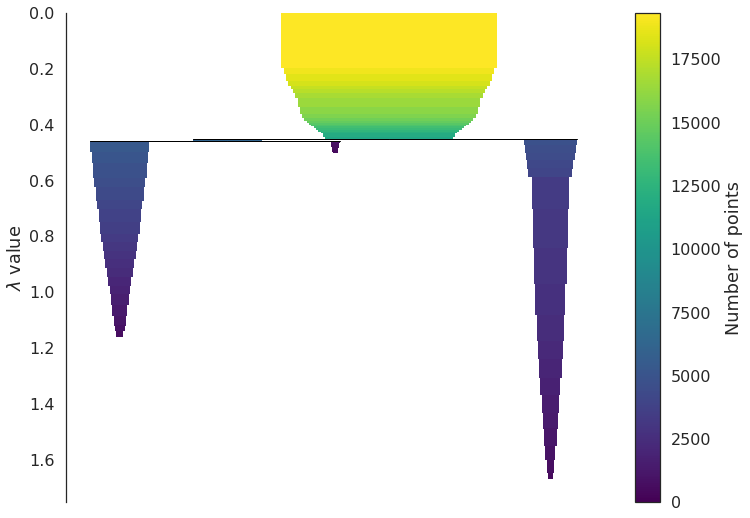

In [10]:
plt.figure(figsize=(12,9))
clusterer.condensed_tree_.plot()

## The circled leafs show the selected clusters by HDBSCAN

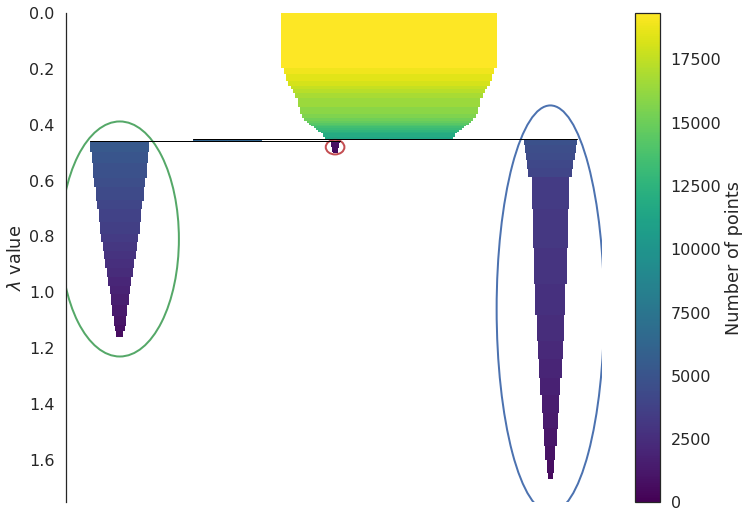

In [11]:
# The Amplitude vs. X position plane
plt.figure(figsize=(12,9))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette('deep',9))

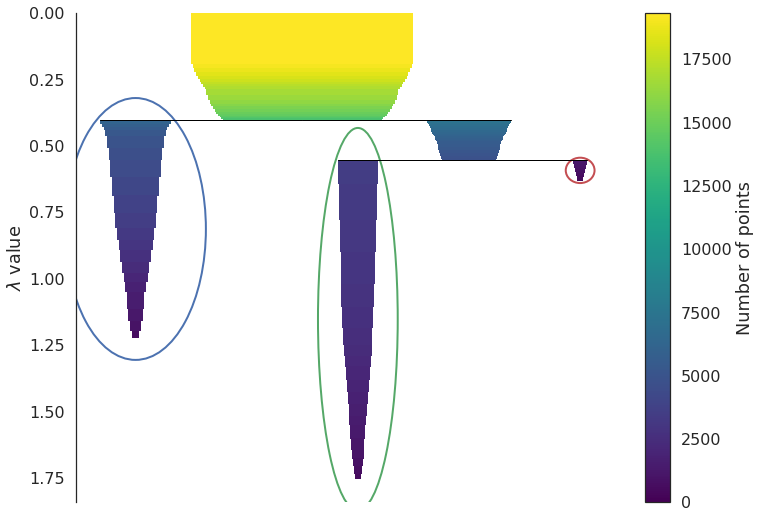

In [12]:
# The Amplitude vs. Y position plane
plt.figure(figsize=(12,9))
clusterer1.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette('deep',9))

## Each cluster is assigned a label ( -1 being noise)

In [14]:
Clustered_data = clusterer.labels_
Clustered_data1 = clusterer1.labels_

Text(0,0.5,'Counts')

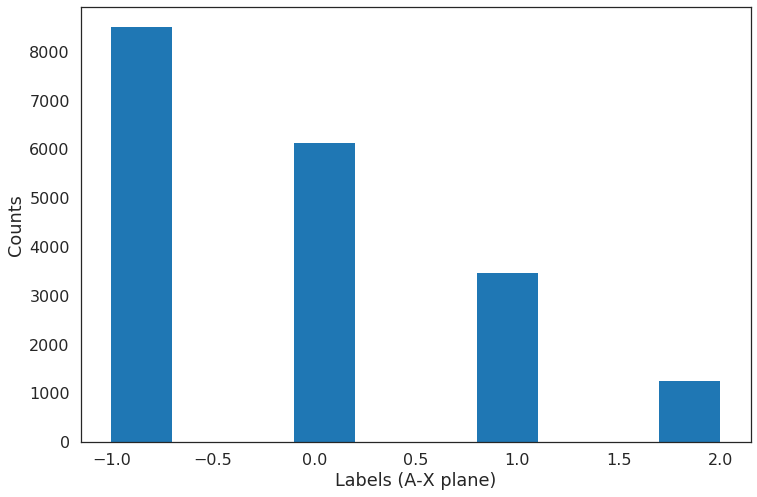

In [17]:
plt.figure(figsize=(12,8))
plt.hist(Clustered_data1);
plt.xlabel('Labels (A-X plane)')
plt.ylabel('Counts')

Text(0,0.5,'Counts')

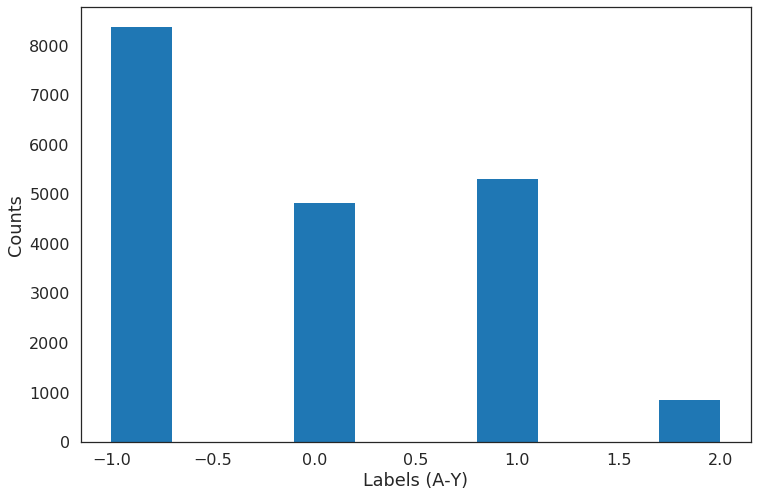

In [18]:
plt.figure(figsize=(12,8))
plt.hist(Clustered_data);
plt.xlabel('Labels (A-Y)')
plt.ylabel('Counts')

## Clusters A-X plane

<Figure size 1080x720 with 0 Axes>

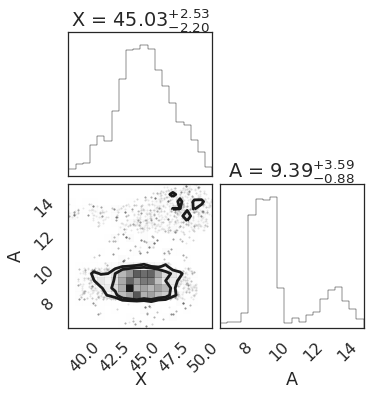

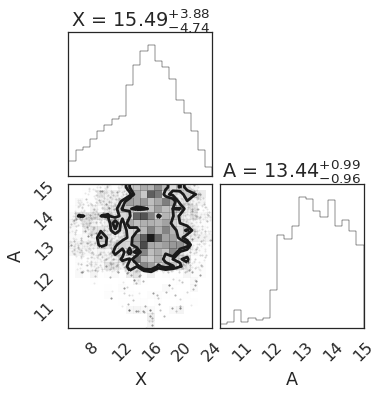

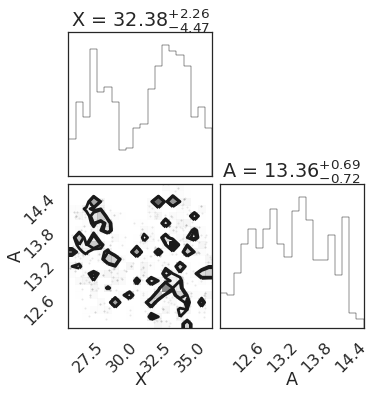

In [64]:
# Clusters X
plt.figure(figsize=(15,10))
for i in range(0,3):
    
    
    cluster = Data_use[np.where(Clustered_data==i)]
    corner.corner(cluster,labels=['X','A'],show_titles=True,bins=20,levels=[0.5,0.65])
    


<Figure size 1080x720 with 0 Axes>

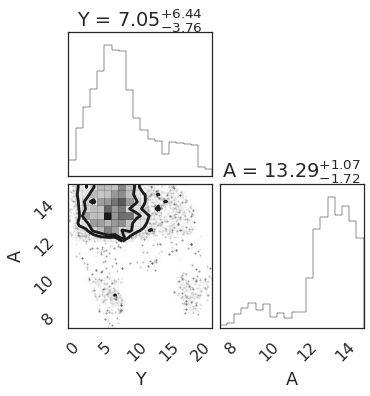

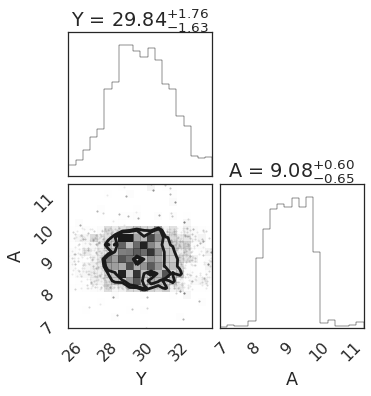

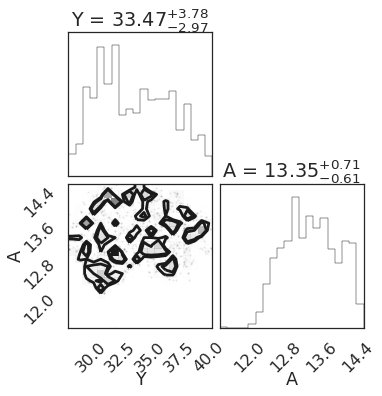

In [71]:
# Clusters Y
plt.figure(figsize=(15,10))
for i in range(0,3):
    cluster1 = Data_use_y[np.where(Clustered_data1==i)]
    corner.corner(cluster1,labels=['Y','A'],show_titles=True,bins=20,levels=[0.5,0.65])
 

Text(0,0.5,'Amplitude')

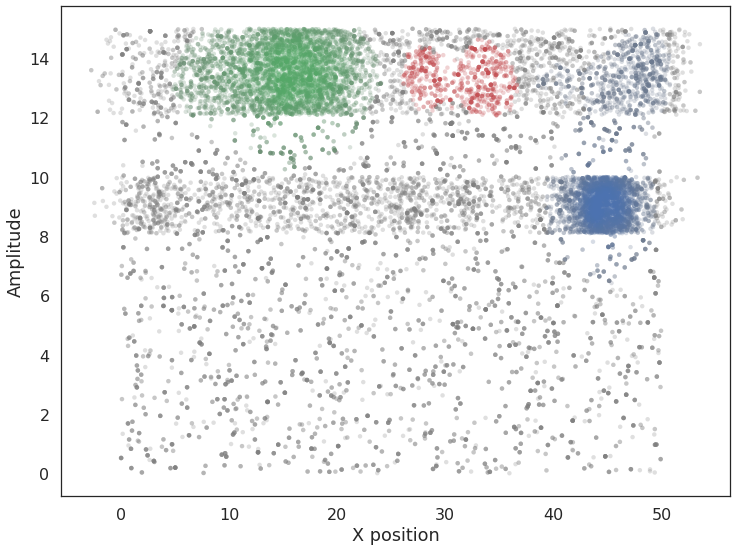

In [26]:
plt.figure(figsize=(12,9))

pal = sns.color_palette('deep', 8)
cluster_colors = [sns.desaturate(pal[col], sat) 
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in 
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(X_position_cl, A_amplitude_cl, c=cluster_colors, **plot_kwds)
plt.xlabel('X position')
plt.ylabel('Amplitude')

Text(0,0.5,'Amplitude')

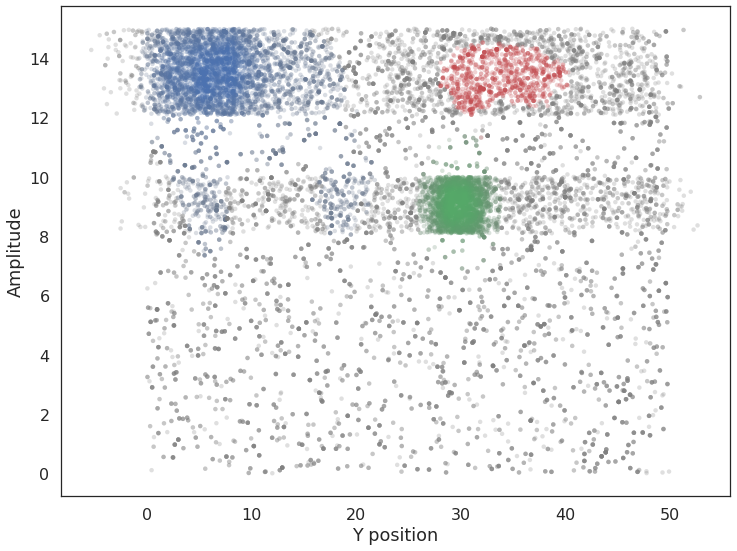

In [27]:
plt.figure(figsize=(12,9))

pal = sns.color_palette('deep', 8)
cluster_colors = [sns.desaturate(pal[col], sat) 
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in 
                  zip(clusterer1.labels_, clusterer1.probabilities_)]
plt.scatter(Y_position_cl, A_amplitude_cl, c=cluster_colors, **plot_kwds)
plt.xlabel('Y position')
plt.ylabel('Amplitude')

# Soft clustering

In [ ]:
def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
        points = raw_tree['child'][(raw_tree['parent'] == leaf) & 
                                   (raw_tree['lambda_val'] == max_lambda)]
        result = np.hstack((result, points))
    return result.astype(np.int)

In [ ]:
plt.figure(figsize=(12,9))
tree = clusterer.condensed_tree_
plt.scatter(X_position_cl, A_amplitude_cl, c='grey', **plot_kwds)
for i, c in enumerate(tree._select_clusters()):
    c_exemplars = exemplars(c, tree)
    plt.scatter(X_position_cl[c_exemplars], A_amplitude_cl[c_exemplars], c=palette[i], **plot_kwds)

In [ ]:
def min_dist_to_exemplar(point, cluster_exemplars, data):
    dists = cdist([data[point]], data[cluster_exemplars.astype(np.int32)])
    return dists.min()

def dist_vector(point, exemplar_dict, data):
    result = {}
    for cluster in exemplar_dict:
        result[cluster] = min_dist_to_exemplar(point, exemplar_dict[cluster], data)
    return np.array(list(result.values()))
    
def dist_membership_vector(point, exemplar_dict, data, softmax=False):
    if softmax:
        result = np.exp(1./dist_vector(point, exemplar_dict, data))
        result[~np.isfinite(result)] = np.finfo(np.double).max
    else:
        result = 1./dist_vector(point, exemplar_dict, data)
        result[~np.isfinite(result)] = np.finfo(np.double).max
    result /= result.sum()
    return result

In [ ]:
plt.figure(figsize=(12,9))
exemplar_dict = {c:exemplars(c,tree) for c in tree._select_clusters()}
colors = np.empty((Data_use.shape[0], 3))
for x in range(Data_use.shape[0]):
    membership_vector = dist_membership_vector(x, exemplar_dict, Data_use)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(X_position_cl,A_amplitude_cl, c=colors, **plot_kwds);

In [ ]:
def max_lambda_val(cluster, tree):
    cluster_tree = tree[tree['child_size'] > 1]
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster)
    max_lambda = 0.0
    for leaf in leaves:
        max_lambda = max(max_lambda, 
                         tree['lambda_val'][tree['parent'] == leaf].max())
    return max_lambda

def points_in_cluster(cluster, tree):
    leaves = hdbscan.plots._recurse_leaf_dfs(tree, cluster)
    return leaves

In [ ]:
def merge_height(point, cluster, tree, point_dict):
    cluster_row = tree[tree['child'] == cluster]
    cluster_height = cluster_row['lambda_val'][0]
    if point in point_dict[cluster]:
        merge_row = tree[tree['child'] == float(point)][0]
        return merge_row['lambda_val']
    else:
        while point not in point_dict[cluster]:
            parent_row = tree[tree['child'] == cluster]
            cluster = parent_row['parent'].astype(np.float64)[0]
        for row in tree[tree['parent'] == cluster]:
            child_cluster = float(row['child'])
            if child_cluster == point:
                return row['lambda_val']
            if child_cluster in point_dict and point in point_dict[child_cluster]:
                return row['lambda_val']

In [ ]:
def per_cluster_scores(point, cluster_ids, tree, max_lambda_dict, point_dict):
    result = {}
    point_row = tree[tree['child'] == point]
    point_cluster = float(point_row[0]['parent'])
    max_lambda = max_lambda_dict[point_cluster] + 1e-8 # avoid zero lambda vals in odd cases
    
    for c in cluster_ids:
        height = merge_height(point, c, tree, point_dict)
        result[c] = (max_lambda / (max_lambda - height))
    return result

In [ ]:
def outlier_membership_vector(point, cluster_ids, tree, 
                              max_lambda_dict, point_dict, softmax=True):
    if softmax:
        result = np.exp(np.array(list(per_cluster_scores(point, 
                                                         cluster_ids, 
                                                         tree,
                                                         max_lambda_dict,
                                                         point_dict
                                                        ).values())))
        result[~np.isfinite(result)] = np.finfo(np.double).max
    else:
        result = np.array(list(per_cluster_scores(point, 
                                                  cluster_ids, 
                                                  tree,
                                                  max_lambda_dict,
                                                  point_dict
                                                 ).values()))
    result /= result.sum()
    return result

In [ ]:
plt.figure(figsize=(12,9))
cluster_ids = tree._select_clusters()
raw_tree = tree._raw_tree
all_possible_clusters = np.arange(Data_use.shape[0], raw_tree['parent'].max() + 1).astype(np.float64)
max_lambda_dict = {c:max_lambda_val(c, raw_tree) for c in all_possible_clusters}
point_dict = {c:set(points_in_cluster(c, raw_tree)) for c in all_possible_clusters}
colors = np.empty((Data_use.shape[0], 3))
for x in range(Data_use.shape[0]):
    membership_vector = outlier_membership_vector(x, cluster_ids, raw_tree, 
                                                  max_lambda_dict, point_dict, False)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(X_position_cl,A_amplitude_cl, c=colors, **plot_kwds);

In [ ]:
def combined_membership_vector(point, data, tree, exemplar_dict, cluster_ids,
                               max_lambda_dict, point_dict, softmax=False):
    raw_tree = tree._raw_tree
    dist_vec = dist_membership_vector(point, exemplar_dict, data, softmax)
    outl_vec = outlier_membership_vector(point, cluster_ids, raw_tree, 
                                         max_lambda_dict, point_dict, softmax)
    result = dist_vec * outl_vec
    result /= result.sum()
    return result

In [ ]:
colors = np.empty((Data_use.shape[0], 3))
for x in range(Data_use.shape[0]):
    membership_vector = combined_membership_vector(x, Data_use, tree, exemplar_dict, cluster_ids,
                                                   max_lambda_dict, point_dict, False)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(X_position_cl,A_amplitude_cl, c=colors, **plot_kwds);

In [ ]:
def prob_in_some_cluster(point, tree, cluster_ids, point_dict, max_lambda_dict):
    heights = []
    for cluster in cluster_ids:
        heights.append(merge_height(point, cluster, tree._raw_tree, point_dict))
    height = max(heights)
    nearest_cluster = cluster_ids[np.argmax(heights)]
    max_lambda = max_lambda_dict[nearest_cluster]
    return height / max_lambda

In [ ]:
plt.figure(figsize=(12,9))
colors = np.empty((Data_use.shape[0], 3))
for x in range(Data_use.shape[0]):
    membership_vector = combined_membership_vector(x, Data_use, tree, exemplar_dict, cluster_ids,
                                                   max_lambda_dict, point_dict, False)
    membership_vector *= prob_in_some_cluster(x, tree, cluster_ids, point_dict, max_lambda_dict)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(X_position_cl,A_amplitude_cl, c=colors, **plot_kwds);